In [72]:
import praw
import re
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from configparser import ConfigParser
config = ConfigParser()
config.read('gradschoolconfig.ini')

reddit = praw.Reddit(user_agent=config.get('main', 'user_agent'),
                     client_id=config.get('main', 'client_id'), 
                     client_secret=config.get('main', 'client_secret'),
                     username=config.get('main', 'username'), 
                     password=config.get('main', 'password'))

print(reddit.random_subreddit())

stupidpol


In [73]:
submission = reddit.submission(url='https://www.reddit.com/r/OMSCS/comments/f3ihka/fall_2020_admissions_thread/')
submission.comments.replace_more(limit=None)

applications = {'Status':[], 'Application Date':[], 'Decision Date':[],
                'Institute Acceptance Date':[], 'Education':[],'Experience':[],
                'Recommendations':[],'Comments':[]}

for comment in tqdm_notebook(submission.comments):
    txt = comment.body
    for line in txt.splitlines():
        if any(key in line for key in applications.keys()):
            split = line.split(':')
            
            key = split[0]
            value = ''.join(split[1:])
            
            key = key.strip().strip('\*').strip()
            value = value.strip().strip('\*').strip()
            try:
                applications[key].append(value)
            except:
                print(line)

    maxlen = len(applications[max(applications, key=lambda k: len(applications[k]))])
    for x in applications:
        if len(applications[x])!=maxlen:
            applications[x].extend([np.nan]*(maxlen-len(applications[x])))
            
df = pd.DataFrame(applications)

Indiana State University, M.S. Higher Education, 3.97
GT Professional Education, Full Stack Coding Boot Camp
__Status__: Applied    
__Application Date__: 06/01/2019    
__Decision Date__: N/A    
__Institute Acceptance Date__: N/A    
__Education__:    
__Experience__:     
__Recommendations__: 3    
__Comments__:    
__Status__: Applied    
__Application Date__: 01/06/2020    
__Decision Date__: N/A    
__Institute Acceptance Date__: N/A    
__Education__:    
__Experience__:     
__Recommendations__: 3    
__Comments__:    
- 2019 MA Adolescent Math Education with various specializations



In [74]:
df['Institute Acceptance Date'].unique()

array(['N/A', '03/31/2020', '04/01/20', '<MM/DD/YY>', '', 'NA', 'TBD',
       '04/08/2020', nan, '4/22/2020', '<04/13/20>', '4/1/20',
       '4/13/2020', '04/02/2020', 'n/a', '(TBD)',
       'Awaiting Institute Acceptance', '04/22/2020', 'Pending', '?',
       'Accepted', 'M/A'], dtype=object)

In [109]:
df = pd.DataFrame(applications)
print(df.shape)
df = df.dropna(subset=['Status'])

df.replace('',np.nan, inplace=True)
df.dropna(how='all', inplace=True)
df.replace('N/A',np.nan, inplace=True)
df.replace('NA',np.nan,inplace=True)
df.replace('n/a',np.nan,inplace=True)
df.replace('TBD',np.nan,inplace=True)

df['Status'] = df['Status'].str.lower()
df['Status'] = df['Status'].map(lambda x: re.sub(r'\W+', '', x))
df['Status'] = df['Status'].replace({'pending':'applied','appliedpending':'applied','acceptedholypotato':'accepted',
                      'acceptedbydepartment':'accepted','applieddeptdecisionmade':'applied'})

df.loc[df['Application Date'].str.contains('[a-zA-Z]',na=False),'Application Date']=np.nan
df.loc[df['Decision Date'].str.contains('[a-zA-Z]',na=False),'Decision Date']=np.nan
df.loc[df['Institute Acceptance Date'].str.contains('[a-zA-Z]',na=False),'Institute Acceptance Date']=np.nan

df['Institute Acceptance Date']=df['Institute Acceptance Date'].str.strip('<>')
df['Institute Acceptance Date'].replace('?',np.nan,inplace=True)

df['Application Date'] = df['Application Date'].str.strip('<>')
df['Application Date'].replace('27/20/20',np.nan,inplace=True)
df['Application Date'].replace('2/29/2019','02/29/2020',inplace=True)
df['Application Date'].replace('02/29/2019','02/29/2020',inplace=True)
df['Application Date'].replace('02/02/20','02/02/2020',inplace=True)
df['Application Date'] = pd.to_datetime(df['Application Date'])

df['Decision Date'] = df['Decision Date'].str.strip('<>')
df['Decision Date'].replace('04/14/3020','04/14/2020', inplace=True)
df['Decision Date'].replace('04/09','04/09/2020', inplace=True)
df['Decision Date'].replace('4/15/2015',np.nan, inplace=True)
df['Decision Date'] = pd.to_datetime(df['Decision Date'])

df['Institute Acceptance Date'] = pd.to_datetime(df['Institute Acceptance Date'])

df.drop(index=34, inplace=True)

print(df.shape)

(244, 8)
(241, 8)


In [111]:
df.head()

,Status,Application Date,Decision Date,Institute Acceptance Date,Education,Experience,Recommendations,Comments
0,accepted,2019-11-07,2020-04-02,NaT,"Mid-tier state school, BS, EE, \~2.6 GPA","1 Year, ML Engineer at Fortune 10",3,Hopefully gives some hope to my fellow landfil...
1,applied,2020-02-25,NaT,NaT,NaN,NaN,NaN,NaN
2,accepted,2020-02-24,2020-04-03,NaT,"BS Statistics and Data Analytics, 3.72, Large ...",NaN,3,"Pretty shocked I heard back so soon, but super..."
3,accepted,2019-08-25,NaT,2020-03-31,NaN,NaN,3,Fingers crossed.
4,accepted,2020-01-27,2020-04-07,NaT,"University of Waterloo, Bachelor of Mathematic...",2 years of internships at various banks and te...,"CS professor from undergrad, manager from an i...",So excited to start the learning grind again!!...


In [112]:
summarydf = pd.DataFrame()
summarydf['counts'] = df['Status'].value_counts()
summarydf['percentage']=df['Status'].value_counts(normalize=True)
summarydf

,counts,percentage
accepted,142,0.589212
applied,85,0.352697
todeptforreview,8,0.033195
rejected,6,0.024896


Text(0, 0.5, 'Application Date')

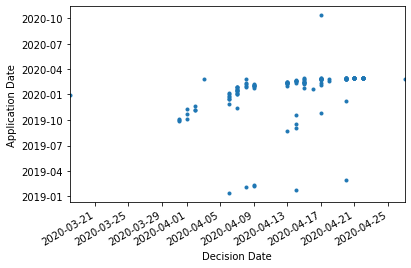

In [113]:
t = df.dropna(subset=['Application Date','Decision Date'])
ax=t.plot('Decision Date','Application Date', style='.',legend=False)
ax.set_ylabel('Application Date')

Text(0, 0.5, 'Application Date')

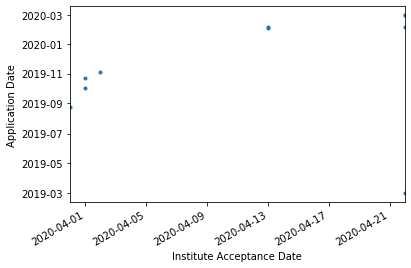

In [114]:
t = df.dropna(subset=['Application Date','Institute Acceptance Date'])
ax=t.plot('Institute Acceptance Date','Application Date', style='.',legend=False)
ax.set_ylabel('Application Date')

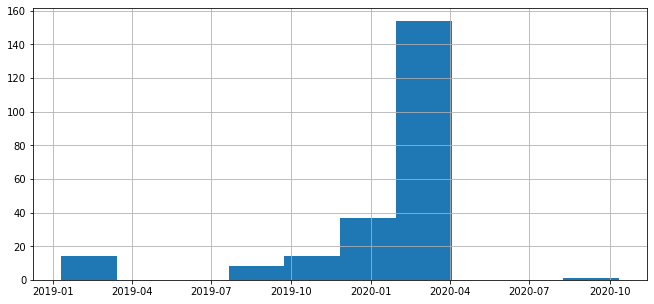

In [115]:
df['Application Date'].hist(figsize=(11,5))

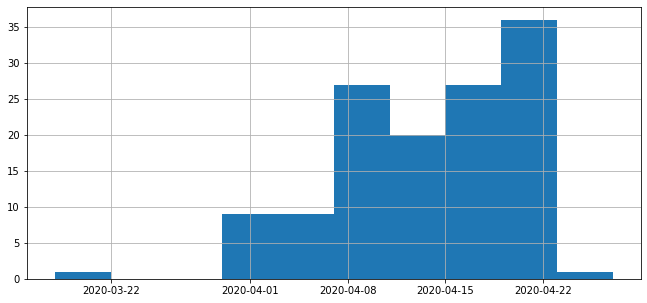

In [116]:
df['Decision Date'].hist(figsize=(11,5))

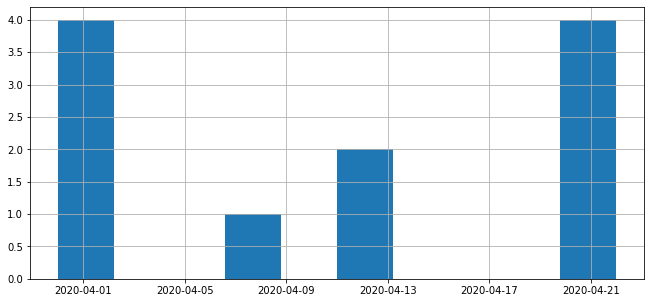

In [117]:
df['Institute Acceptance Date'].hist(figsize=(11,5))

In [118]:
df.describe()

,Status,Application Date,Decision Date,Institute Acceptance Date,Education,Experience,Recommendations,Comments
count,241,228,130,11,98,142,198,122
unique,4,87,19,6,98,142,128,122
top,accepted,2020-02-29 00:00:00,2020-04-20 00:00:00,2020-04-22 00:00:00,"BSc. EE, State School in Ethiopia, 3.02/4.0. T...","1 year, GE",3,Really looking forward to the program!
freq,142,36,13,4,1,1,65,1
first,NaN,2019-01-10 00:00:00,2020-03-18 00:00:00,2020-03-31 00:00:00,NaN,NaN,NaN,NaN
last,NaN,2020-10-12 00:00:00,2020-04-27 00:00:00,2020-04-22 00:00:00,NaN,NaN,NaN,NaN
